# One-Layer Neural Network from scratch




In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings('ignore')

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

np.random.seed(1) # set a seed so that the results are consistent

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## Load Datasets

In [3]:
# Load the data from h5 file
def load_dataset():
#     train_dataset = h5py.File('/content/gdrive/My Drive/CoderSchool-FTMLE/data/datasets/catdog/catsvsdogs-train.h5', "r")
    train_dataset = h5py.File('./data/catsvsdogs-train.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:]) # your train set labels
    
#     test_dataset = h5py.File('/content/gdrive/My Drive/CoderSchool-FTMLE/data/datasets/catdog/catsvsdogs-test.h5', "r")
    test_dataset = h5py.File('./data/catsvsdogs-test.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [4]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

### Resize Images

In [5]:
def resize_image(dataset):
  resize_ratio = 1.5

  resized_dataset = np.empty([len(dataset), int(dataset[1].shape[0] // resize_ratio), int(dataset[1].shape[1] // resize_ratio), dataset[1].shape[2]])

  for i in range(0, len(dataset)):
    image = dataset[i]
    image_resized = resize(image, (image.shape[0] // resize_ratio, image.shape[1] // resize_ratio), anti_aliasing=True)
    resized_dataset[i] = image_resized
  
  return resized_dataset

train_set_x_resized = resize_image(train_set_x_orig)
test_set_x_resized = resize_image(test_set_x_orig)

original dataset shape: (5000, 128, 128, 3)
resized dataset shape: (5000, 85, 85, 3)


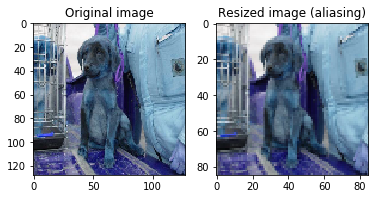

In [6]:
print("original dataset shape:", train_set_x_orig.shape)
print("resized dataset shape:", train_set_x_resized.shape)

index_1 = np.random.randint(0,len(train_set_x_orig)) 

fig, axes = plt.subplots(nrows=1, ncols=2)

ax = axes.ravel()

ax[0].imshow(train_set_x_orig[index_1], cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(train_set_x_resized[index_1], cmap='gray')
ax[1].set_title("Resized image (aliasing)")

plt.show()

### Convert images to 1-channel color mode

In [35]:
def grayscale_convert(dataset):
  grayscale_dataset = np.empty([len(dataset), dataset[1].shape[0], dataset[1].shape[1]])
  
  for i in range(0, len(dataset)):
    image = dataset[i]
    image_grayscale = image.dot([0.07, 0.72, 0.21])
    grayscale_dataset[i] = image_grayscale
      
  return grayscale_dataset

train_set_x_grayscale = grayscale_convert(train_set_x_orig)
test_set_x_grayscale = grayscale_convert(test_set_x_orig)

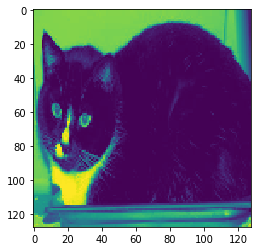

In [36]:
plt.imshow(train_set_x_grayscale[21])

### EDA

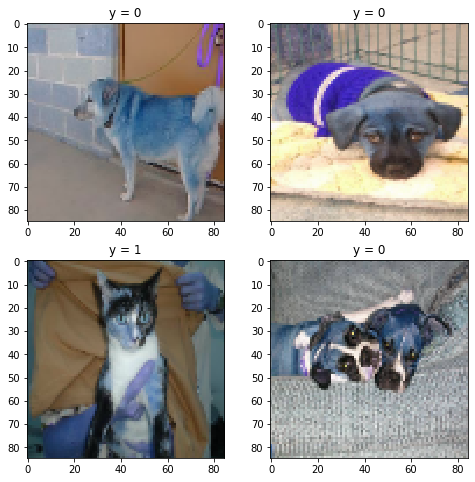

In [9]:
# Some some random images and their labels
plt.subplots(figsize = (8,8))
plt.subplot(221)
index_1 = np.random.randint(0,len(train_set_x_resized)) 
plt.imshow(train_set_x_resized[index_1])
plt.title("y = " + str(train_set_y_orig[index_1]))

plt.subplot(222)
index_2 = np.random.randint(0,len(train_set_x_resized))
plt.imshow(train_set_x_resized[index_2])
plt.title("y = " + str(train_set_y_orig[index_2]))

plt.subplot(223)
index_3 = np.random.randint(0,len(train_set_x_resized))
plt.imshow(train_set_x_resized[index_3])
plt.title("y = " + str(train_set_y_orig[index_3]))

plt.subplot(224)
index_4 = np.random.randint(0,len(train_set_x_resized))
plt.imshow(train_set_x_resized[index_4])
plt.title("y = " + str(train_set_y_orig[index_4]))

plt.show()

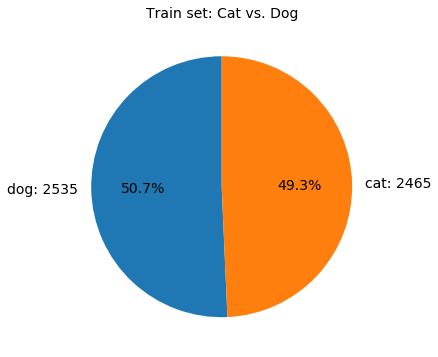

In [10]:
# Visualization the train set labels
unique, counts = np.unique(train_set_y_orig, return_counts = True)
dict1 = dict(zip(unique, counts))
plt.figure(figsize=(6,6))
plt.pie(x = counts, labels = ['dog: %s' % counts[0],'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Train set: Cat vs. Dog', fontdict={'fontsize': 14})
plt.show()

## Implement neuron networks model from scratch

## Building model

In this notebook, you will implement all the functions required to build a deep neural network.

![](https://i.imgur.com/ivhZhmx.png)

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).
    
The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_params`, you should make sure that your dimensions match between each layer. Given $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

| |**Shape of W**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |**Shape of b**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Shape of Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:-|:-|:-|:-|:-|
|**Layer 1**|$(n^{[1]},12288)$|$(n^{[1]},1)$|$Z^{[1]} = W^{[1]}  X + b^{[1]} $|$(n^{[1]},209)$|
| **Layer 2**|$(n^{[2]}, n^{[1]})$|$(n^{[2]},1)$|$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$|$(n^{[2]}, 209)$|
|$\vdots$| $\vdots$ | $\vdots$|$\vdots$|$\vdots$|
|**Layer L-1** | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$|
|**Layer L** | $(n^{[L]}, n^{[L-1]})$ | $(n^{[L]}, 1)$|  $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$|$(n^{[L]}, 209)$ |

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

### sigmoid, relu, layer_sizes

In [11]:
def sigmoid(Z):
  return 1/(1 + np.exp(-Z))

In [12]:
def relu(Z):
  return np.maximum(0, Z)

In [13]:
def relu_backward(Z):
  temp = np.ones(Z.shape)
  temp[Z<0] = 0
  return temp

In [14]:
def layer_sizes(X, Y, hidden_layers):
  layer_dims = np.array(hidden_layers, copy = True)
  
  layer_dims = np.insert(layer_dims, 0, X.shape[1])
  layer_dims = np.append(layer_dims, Y.shape[0])
  
  return layer_dims

### initialize

In [15]:
def initialize_params(layer_dims):
  np.random.seed(1)
  
  params = {}
  L = len(layer_dims)
  n_x = layer_dims[0]
    
  for i in range(1, L):
    n_h = layer_dims[i]
    n_x = layer_dims[i-1]
    params['W' + str(i)] = np.random.randn(n_h, n_x) / np.sqrt(n_x)
    params['b' + str(i)] = np.zeros((n_h, 1))
    
    # we use assert to double check the array shape
    assert(params['W' + str(i)].shape == (n_h, n_x))
    assert(params['b' + str(i)].shape == (n_h, 1))
  
  return params

### forward_propagation

In [16]:
def forward_propagation(X, params):    
  caches = {}
  A_prev = X.T
  L = len(params) // 2
  
  for i in range(1, L):
    bi = params['b' + str(i)]
    Wi = params['W' + str(i)]
    Zi = np.dot(Wi, A_prev) + bi
    Ai = relu(Zi)
    
    caches['A' + str(i)] = Ai
    caches['Z' + str(i)] = Zi
    
    A_prev = Ai
  
  Z_last = np.dot(params['W' + str(L)], caches['A' + str(L-1)]) + params['b' + str(L)]
  A_last = sigmoid(Z_last)
    
  caches['A' + str(L)] = A_last
  caches['Z' + str(L)] = Z_last
  
  return A_last, caches

### compute J

In [17]:
def compute_cross_entropy_cost(Y, A_last):
  m = Y.shape[1]
  
  loss = np.multiply(Y, np.log(A_last)) + np.multiply(1 - Y, np.log(1 - A_last))
  J = (-1/m) * np.sum(loss)
  J = np.squeeze(J) # np.squeeze(24) => 24
  
  return J

### backward_propagation

In [18]:
def backward_propagation(X, Y, params, caches):
  m = X.shape[0]
  L = len(params) // 2
  grads = {}
    
  A_last_prev = caches['A' + str(L-1)]
  A_last = caches['A' + str(L)]
  
  dZ_last = A_last - Y
  dW_last = (1/m) * np.dot(dZ_last, A_last_prev.T)
  db_last = (1/m) * np.sum(dZ_last, axis=1, keepdims=True)
  
  grads['dZ' + str(L)] = dZ_last
  grads['dW' + str(L)] = dW_last
  grads['db' + str(L)] = db_last
  
  for i in range(L-1, 0, -1): 
    Wi = params['W' + str(i+1)]
    bi = params['b' + str(i)]
    Ai_prev = caches['A' + str(i-1)] if (i) > 1 else X.T
    Zi = caches['Z' + str(i)]
    
    dZi = np.multiply(np.dot(Wi.T, grads['dZ' + str(i+1)]), relu_backward(Zi))
    dWi = (1/m) * np.dot(dZi, Ai_prev.T)
    dbi = (1/m) * np.sum(dZi, axis=1, keepdims=True)
    
    grads['dZ' + str(i)] = dZi
    grads['dW' + str(i)] = dWi
    grads['db' + str(i)] = dbi
  
  return grads

### update_params

In [19]:
def update_params(params, grads, learning_rate):
  
  L = len(params) // 2
  
  for i in range(1, L+1):
    Wi = params['W' + str(i)]
    bi = params['b' + str(i)]
    dWi = grads['dW' + str(i)]
    dbi = grads['db' + str(i)]
  
    Wi = Wi - learning_rate * dWi
    bi = bi - learning_rate * dbi
  
    params['W' + str(i)] = Wi
    params['b' + str(i)] = bi
    
  return params

## Build our neural network in `dnn_model()`

### dnn_model

In [32]:
def dnn_model(X, Y, hidden_layers, iterations, learning_rate):
  
  costs = []
  test_errors = []
  reports = {}
  
  layer_dims = layer_sizes(X, Y, hidden_layers)
  
  print(layer_dims)
  
  parameters = initialize_params(layer_dims)
  
  for i in range(iterations):
    # forward_probagation
    A_last, caches = forward_propagation(X, parameters)
    # Compute cost
    J = compute_cross_entropy_cost(Y, A_last)
    # backward_probagation
    grads = backward_propagation(X, Y, parameters, caches)
    # Update parameters
    parameters = update_params(parameters, grads, learning_rate)
    
    if i%100 == 0:
      print("Iteration %i, cost %f" % (i, J))
      costs.append(J)
#       A2_test, _ = forward_propagation(X_test, parameters)
#       predictions = A2_test > 0.5
      predictions, A2_test = predict(X_test, parameters)
      test_errors.append(1 - accuracy_score(y_test[0], predictions[0]))
  
  reports['costs'] = costs
  reports['test_errors'] = test_errors
  
  return parameters, reports

### predict

In [21]:
def predict(X, params):
  A_last, cache = forward_propagation(X, params)
  predictions = A_last > 0.5
  return predictions, A_last

### main

In [39]:
# Convert X to 2D array
X_train = train_set_x_grayscale.flatten().reshape((len(train_set_x_grayscale),-1)) / 255
X_test = test_set_x_grayscale.flatten().reshape((len(test_set_x_grayscale),-1)) / 255
# X_train = train_set_x_orig.flatten().reshape((len(train_set_x_orig),-1)) / 255
# X_test = test_set_x_orig.flatten().reshape((len(test_set_x_orig),-1)) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1, -1)
y_test = test_set_y_orig.reshape(1, -1)

In [48]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 16384), (1, 5000), (500, 16384), (1, 500))

In [67]:
# Scale down the train dataset for testing purpose
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train, train_set_y_orig, train_size=0.143, random_state=42)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_train_sample, y_train_sample, train_size=0.7, random_state=42)
y_train_scaled = y_train_scaled.reshape(1, -1)
y_test_scaled = y_test_scaled.reshape(1, -1)

In [68]:
print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)

(499, 16384) (1, 499) (215, 16384) (1, 215)


In [38]:
nn = len(X_train_scaled) / (5 * (5 + 1))
print(nn)

16.666666666666668


In [69]:
hidden_layers = [5, 3]
iterations = 1000
learning_rate = 0.01

t0 = time.time()
parameters, reports = dnn_model(X_train_scaled, y_train_scaled, hidden_layers, iterations, learning_rate)

predictions, A_last = predict(X_test, parameters)
t1 = time.time()
print("run time:", t1 - t0)

[16384     5     3     1]
Iteration 0, cost 0.709899
Iteration 100, cost 0.635038
Iteration 200, cost 0.583660
Iteration 300, cost 0.566420
Iteration 400, cost 0.496557
Iteration 500, cost 0.496091
Iteration 600, cost 0.430611
Iteration 700, cost 0.421160
Iteration 800, cost 0.418313
Iteration 900, cost 0.415400
run time: 8.116559028625488


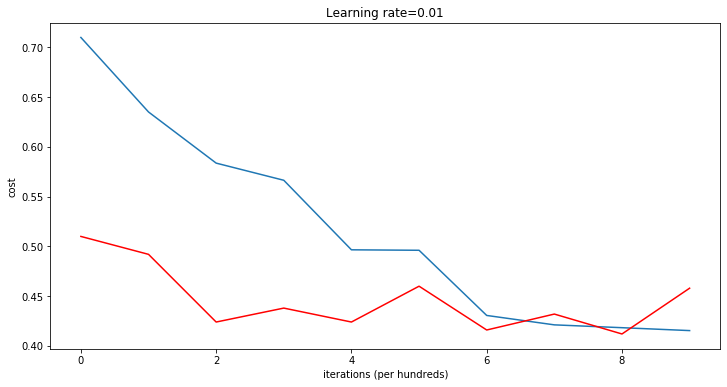

Accuracy Score - Training set: 0.859719
Confusion Matrix:
[[249   5]
 [ 65 180]]


Accuracy Score - Test set: 0.567442
Confusion Matrix:
[[67 31]
 [62 55]]


In [71]:
# plot the cost
fig, ax = plt.subplots(figsize=[12, 6])
plt.plot(reports['costs'])
plt.plot(reports['test_errors'], c='r')
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Learning rate=' + str(learning_rate) )
plt.show()

# show accuracy scores
predictions, A_last = predict(X_train_scaled, parameters)
print("Accuracy Score - Training set: %f" % accuracy_score(y_train_scaled[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_train_scaled[0], predictions[0]))
print('\n')
predictions, A_last = predict(X_test_scaled, parameters)
print("Accuracy Score - Test set: %f" % accuracy_score(y_test_scaled[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_scaled[0], predictions[0]))

### TODO: Save our model

### Print Mislabeled Images

In [29]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[index, :].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

## Model from sklearn

In [26]:
# Create Logistics Regression model from X and y
lg = LogisticRegression()
lg.fit(X_train, y_train[0])

# Show metrics
print("Accuracy Score: %f" % accuracy_score(y_test[0], lg.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], lg.predict(X_test)))

Accuracy Score: 0.576000
Confusion Matrix:
[[130 125]
 [ 87 158]]
